### AE_ts_model

In [42]:
### AE_ts_model.py
"""
Created on Tue Mar 22 10:43:29 2016
@author: Rob Romijnders
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.contrib.rnn import LSTMCell


def open_data(direc, ratio_train=0.8, dataset="ECG5000"):
    """Input:
    direc: location of the UCR archive
    ratio_train: ratio to split training and testset
    dataset: name of the dataset in the UCR archive"""
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.loadtxt(datadir + '_TRAIN', delimiter=',')
    data_test_val = np.loadtxt(datadir + '_TEST', delimiter=',')[:-1]
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape

    ind_cut = int(ratio_train * N)
    ind = np.random.permutation(N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]


def plot_data(X_train, y_train, plot_row=5):
    counts = dict(Counter(y_train))
    num_classes = len(np.unique(y_train))
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):  # Loops over classes, plot as columns
        c = int(c)
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            axarr[n, c].plot(X_train[ind_plot[n], :])
            # Only shops axes for bottom row and left column
            if n == 0: axarr[n, c].set_title('Class %.0f (%.0f)' % (c, counts[float(c)]))
            if not n == plot_row - 1:
                plt.setp([axarr[n, c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n, c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  # No horizontal space between subplots
    f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()
    return


def plot_z_run(z_run, label, ):
    from sklearn.decomposition import TruncatedSVD
    f1, ax1 = plt.subplots(2, 1)

    PCA_model = TruncatedSVD(n_components=3).fit(z_run)
    z_run_reduced = PCA_model.transform(z_run)
    ax1[0].scatter(z_run_reduced[:, 0], z_run_reduced[:, 1], c=label, marker='*', linewidths=0)
    ax1[0].set_title('PCA on z_run')
    ax1[0].legend()
    from sklearn.manifold import TSNE
    tSNE_model = TSNE(verbose=2, perplexity=80, min_grad_norm=1E-12, n_iter=3000)
    z_run_tsne = tSNE_model.fit_transform(z_run)
    ax1[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=label, marker='*', linewidths=0)
    ax1[1].set_title('tSNE on z_run')
    ax1[1].legend()
    return


class Model():
    def __init__(self, config):
        """Hyperparameters"""
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        max_grad_norm = config['max_grad_norm']
        batch_size = config['batch_size']
        sl = config['sl']
        crd = config['crd']
        num_l = config['num_l']
        learning_rate = config['learning_rate']
        self.sl = sl
        self.batch_size = batch_size

        # Nodes for the input variables
        self.x = tf.placeholder("float", shape=[batch_size, sl], name='Input_data')
        self.x_exp = tf.expand_dims(self.x, 1)
        self.keep_prob = tf.placeholder("float")

        with tf.variable_scope("Encoder") as scope:
            # Th encoder cell, multi-layered with dropout
            cell_enc = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])
            cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=self.keep_prob)

            # Initial state
            initial_state_enc = cell_enc.zero_state(batch_size, tf.float32)

        # with tf.name_scope("Enc_2_lat") as scope:
            # layer for mean of z
            W_mu = tf.get_variable('W_mu', [hidden_size, num_l])

            outputs_enc, _ = tf.contrib.rnn.static_rnn(cell_enc,
                                                      inputs=tf.unstack(self.x_exp, axis=2),
                                                      initial_state=initial_state_enc)
            cell_output = outputs_enc[-1]

            b_mu = tf.get_variable('b_mu', [num_l])
            self.z_mu = tf.nn.xw_plus_b(cell_output, W_mu, b_mu, name='z_mu')  # mu, mean, of latent space

            # Train the point in latent space to have zero-mean and unit-variance on batch basis
            lat_mean, lat_var = tf.nn.moments(self.z_mu, axes=[1])
            self.loss_lat_batch = tf.reduce_mean(tf.square(lat_mean) + lat_var - tf.log(lat_var) - 1)

        with tf.name_scope("Lat_2_dec") as scope:
            # layer to generate initial state
            W_state = tf.get_variable('W_state', [num_l, hidden_size])
            b_state = tf.get_variable('b_state', [hidden_size])
            z_state = tf.nn.xw_plus_b(self.z_mu, W_state, b_state, name='z_state')  # mu, mean, of latent space

        with tf.variable_scope("Decoder") as scope:
            # The decoder, also multi-layered
            cell_dec = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])

            # Initial state
            initial_state_dec = tuple([(z_state, z_state)] * num_layers)
            dec_inputs = [tf.zeros([batch_size, 1])] * sl
            # outputs_dec, _ = tf.nn.seq2seq.rnn_decoder(dec_inputs, initial_state_dec, cell_dec)
            outputs_dec, _ = tf.contrib.rnn.static_rnn(cell_dec,
                                                       inputs=dec_inputs,
                                                       initial_state=initial_state_dec)
        with tf.name_scope("Out_layer") as scope:
            params_o = 2 * crd  # Number of coordinates + variances
            W_o = tf.get_variable('W_o', [hidden_size, params_o])
            b_o = tf.get_variable('b_o', [params_o])
            outputs = tf.concat(outputs_dec, axis=0)  # tensor in [sl*batch_size,hidden_size]
            h_out = tf.nn.xw_plus_b(outputs, W_o, b_o)
            h_mu, h_sigma_log = tf.unstack(tf.reshape(h_out, [sl, batch_size, params_o]), axis=2)
            h_sigma = tf.exp(h_sigma_log)
            dist = tf.contrib.distributions.Normal(h_mu, h_sigma)
            px = dist.log_prob(tf.transpose(self.x))
            loss_seq = -px
            self.loss_seq = tf.reduce_mean(loss_seq)

        with tf.name_scope("train") as scope:
            # Use learning rte decay
            global_step = tf.Variable(0, trainable=False)
            lr = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.1, staircase=False)

            self.loss = self.loss_seq + self.loss_lat_batch

            # Route the gradients so that we can plot them on Tensorboard
            tvars = tf.trainable_variables()
            # We clip the gradients to prevent explosion
            grads = tf.gradients(self.loss, tvars)
            grads, _ = tf.clip_by_global_norm(grads, max_grad_norm)
            self.numel = tf.constant([[0]])

            # And apply the gradients
            optimizer = tf.train.AdamOptimizer(lr)
            gradients = zip(grads, tvars)
            self.train_step = optimizer.apply_gradients(gradients, global_step=global_step)
            #      for gradient, variable in gradients:  #plot the gradient of each trainable variable
            #        if isinstance(gradient, ops.IndexedSlices):
            #          grad_values = gradient.values
            #        else:
            #          grad_values = gradient
            #
            #        self.numel +=tf.reduce_sum(tf.size(variable))
            #        tf.summary.histogram(variable.name, variable)
            #        tf.summary.histogram(variable.name + "/gradients", grad_values)
            #        tf.summary.histogram(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))

            self.numel = tf.constant([[0]])
        tf.summary.tensor_summary('lat_state', self.z_mu)
        # Define one op to call all summaries
        self.merged = tf.summary.merge_all()
        # and one op to initialize the variables
        self.init_op = tf.global_variables_initializer()

## AE_ts_main

In [43]:
### Read data
import numpy as np
from scipy import stats
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os

In [44]:
# Import all labeled files
path = os.path.expanduser("~/Dropbox/data/labeledData/")
fileInList = list(os.path.join(path+f) for f in os.listdir(path))
data = pd.concat((pd.read_csv(f) for f in fileInList))

# Import individual labeled files
# data = pd.read_csv('./data/processedData/10-07-20-08.csv')
# data = pd.read_csv('./data/processedData/12-07-18-08.csv')
# data = pd.concat([data1, data2])

105494


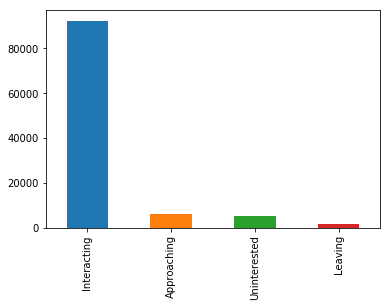

In [45]:
print(data.shape[0])
data['Activity'].value_counts().plot(kind='bar')

In [46]:
# Data preprocessing
featureNames = list(data.columns)
featureNames.remove('Activity')

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

data.dropna(axis=0, how='any', inplace= True)
for i in range(1,len(featureNames)):
    if featureNames[i] == 'timeStamp':
        pass
    else:
        data[featureNames[i]] = feature_normalize(data[featureNames[i]]) 
        
def timeStampToFloat(stringTime):
    splitTime = stringTime.split(':')
    hour = float(splitTime[0]) * 3600
    minutes = float(splitTime[1]) * 60
    return hour + minutes + float(splitTime[2])

data['timeStamp'] = data['timeStamp'].apply(timeStampToFloat)

In [47]:
# Separate X and Y
X = data.iloc[:,:58]
Y = data['Activity']
# print(Y.unique())
# Y.value_counts().plot(kind='bar')

In [48]:
X = X.as_matrix()

/home/gvlablinux/anaconda3/envs/tfPython3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [49]:
Y = Y.map( {'Approaching': 0, 'Interacting': 1, 'Leaving': 2, 'Uninterested': 3} ).astype(int)

In [50]:
Y = Y.as_matrix()

/home/gvlablinux/anaconda3/envs/tfPython3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [51]:
from sklearn.cross_validation import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.35)

In [61]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 22 10:43:29 2016
@author: Rob Romijnders
"""

import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.contrib.tensorboard.plugins import projector
# from AE_ts_model import Model, open_data, plot_data, plot_z_run

"""Hyperparameters"""
# direc = '/home/rob/Dropbox/ml_projects/LSTM/UCR_TS_Archive_2015'
LOG_DIR = "/home/gvlablinux/autoEncoder/.summaries"
config = {}  # Put all configuration information into the dict
config['num_layers'] = 2  # number of layers of stacked RNN's
config['hidden_size'] = 90  # memory cells in a layer
config['max_grad_norm'] = 5  # maximum gradient norm during training
config['batch_size'] = batch_size = 64
config['learning_rate'] = .005
config['crd'] = 1  # Hyperparameter for future generalization
config['num_l'] = 20  # number of units in the latent space

plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 1000  # maximum number of iterations
dropout = 0.8  # Dropout rate
"""Load the data"""
# X_train, X_val, y_train, y_val = open_data('/home/rob/Dropbox/ml_projects/LSTM/UCR_TS_Archive_2015')

N = X_train.shape[0]
Nval = X_val.shape[0]
D = X_train.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N, D))

# Organize the classes
num_classes = len(np.unique(y_train))
# base = np.min(y_train)  # Check if data is 0-based
# if base != 0:
#     y_train -= base
#     y_val -= base

# Plot data   # and save high quality plt.savefig('data_examples.eps', format='eps', dpi=1000)
# plot_data(X_train, y_train)

# Proclaim the epochs
# epochs = np.floor(batch_size * max_iterations / N)
epochs = 10
print('Train with approximately %d epochs' % epochs)

We have 68571 observations with 58 dimensions
Train with approximately 10 epochs


In [64]:
"""Training time!"""
tf.reset_default_graph()
model = Model(config)

sess = tf.Session()
perf_collect = np.zeros((2, int(np.floor(max_iterations / plot_every))))

In [65]:
if True:
    sess.run(model.init_op)
    writer = tf.summary.FileWriter(LOG_DIR, sess.graph)  # writer for Tensorboard

    step = 0  # Step is a counter for filling the numpy array perf_collect
    for i in range(max_iterations):
        batch_ind = np.random.choice(N, batch_size, replace=False)
        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                          feed_dict={model.x: X_train[batch_ind], model.keep_prob: dropout})

        if i % plot_every == 0:
            # Save train performances
            perf_collect[0, step] = loss_train = result[0]
            loss_train_seq, lost_train_lat = result[1], result[2]

            # Calculate and save validation performance
            batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

            result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                              feed_dict={model.x: X_val[batch_ind_val], model.keep_prob: 1.0})
            perf_collect[1, step] = loss_val = result[0]
            loss_val_seq, lost_val_lat = result[1], result[2]
            # and save to Tensorboard
            summary_str = result[3]
            writer.add_summary(summary_str, i)
            writer.flush()

            print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
            i, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
            step += 1
if False:
    ##Extract the latent space coordinates of the validation set
    start = 0
    label = []  # The label to save to visualize the latent space
    z_run = []

    while start + batch_size < Nval:
        run_ind = range(start, start + batch_size)
        z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: X_val[run_ind], model.keep_prob: 1.0})
        z_run.append(z_mu_fetch)
        start += batch_size

    z_run = np.concatenate(z_run, axis=0)
    label = y_val[:start]

    plot_z_run(z_run, label)

# Save the projections also to Tensorboard
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step)
config = projector.ProjectorConfig()
# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = model.z_mu.name
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Saves a configuration file that TensorBoard will read during startup.
projector.visualize_embeddings(writer, config)
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step + 1)
writer.flush()



# Now open Tensorboard with
#  $tensorboard --logdir = LOG_DIR

At      0 /   1000 train (20097358.000, 20097356.000, 1.889), val (12707016.000, 12707014.000,1.774) in order (total, seq, lat)
At    100 /   1000 train (4.977, 4.964, 0.013), val (4.952, 4.951,0.001) in order (total, seq, lat)
At    200 /   1000 train (2.242, 2.238, 0.004), val (2.212, 2.211,0.001) in order (total, seq, lat)
At    300 /   1000 train (29.560, 29.556, 0.004), val (1.936, 1.935,0.001) in order (total, seq, lat)
At    400 /   1000 train (2.390, 2.386, 0.004), val (1.972, 1.971,0.000) in order (total, seq, lat)
At    500 /   1000 train (1.642, 1.638, 0.004), val (1.850, 1.849,0.001) in order (total, seq, lat)
At    600 /   1000 train (1.781, 1.776, 0.004), val (1.941, 1.940,0.002) in order (total, seq, lat)
At    700 /   1000 train (1.888, 1.885, 0.003), val (1.696, 1.695,0.001) in order (total, seq, lat)
At    800 /   1000 train (1.863, 1.859, 0.004), val (1.813, 1.812,0.002) in order (total, seq, lat)
At    900 /   1000 train (1.922, 1.918, 0.004), val (1.657, 1.656,0.00

No handles with labels found to put in legend.


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 36864 samples in 0.044s...
[t-SNE] Computed neighbors for 36864 samples in 3.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36864
[t-SNE] Computed conditional probabilities for sample 2000 / 36864
[t-SNE] Computed conditional probabilities for sample 3000 / 36864
[t-SNE] Computed conditional probabilities for sample 4000 / 36864
[t-SNE] Computed conditional probabilities for sample 5000 / 36864
[t-SNE] Computed conditional probabilities for sample 6000 / 36864
[t-SNE] Computed conditional probabilities for sample 7000 / 36864
[t-SNE] Computed conditional probabilities for sample 8000 / 36864
[t-SNE] Computed conditional probabilities for sample 9000 / 36864
[t-SNE] Computed conditional probabilities for sample 10000 / 36864
[t-SNE] Computed conditional probabilities for sample 11000 / 36864
[t-SNE] Computed conditional probabilities for sample 12000 / 36864
[t-SNE] Computed conditional probabilities for sa

[t-SNE] Iteration 2900: error = 0.5671211, gradient norm = 0.0000215 (50 iterations in 51.856s)
[t-SNE] Iteration 2950: error = 0.5660994, gradient norm = 0.0000213 (50 iterations in 52.479s)


No handles with labels found to put in legend.


[t-SNE] Iteration 3000: error = 0.5650359, gradient norm = 0.0000204 (50 iterations in 52.781s)
[t-SNE] Error after 3000 iterations: 0.565036


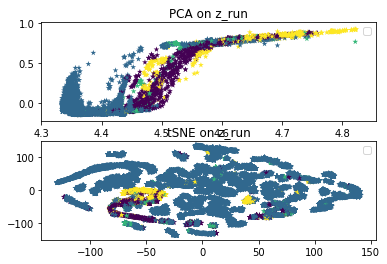

In [66]:
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: X_val[run_ind], model.keep_prob: 1.0})
    z_run.append(z_mu_fetch)
    start += batch_size

z_run = np.concatenate(z_run, axis=0)
label = y_val[:start]

plot_z_run(z_run, label)

No handles with labels found to put in legend.


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 6848 samples in 0.006s...
[t-SNE] Computed neighbors for 6848 samples in 0.335s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6848
[t-SNE] Computed conditional probabilities for sample 2000 / 6848
[t-SNE] Computed conditional probabilities for sample 3000 / 6848
[t-SNE] Computed conditional probabilities for sample 4000 / 6848
[t-SNE] Computed conditional probabilities for sample 5000 / 6848
[t-SNE] Computed conditional probabilities for sample 6000 / 6848
[t-SNE] Computed conditional probabilities for sample 6848 / 6848
[t-SNE] Mean sigma: 0.011600
[t-SNE] Computed conditional probabilities in 0.999s
[t-SNE] Iteration 50: error = 71.7721710, gradient norm = 0.0305266 (50 iterations in 8.856s)
[t-SNE] Iteration 100: error = 58.2559547, gradient norm = 0.0057822 (50 iterations in 8.079s)
[t-SNE] Iteration 150: error = 55.3278809, gradient norm = 0.0032971 (50 iterations in 7.966s)
[t-SNE] Iteration 200: error =

No handles with labels found to put in legend.


[t-SNE] Iteration 3000: error = 0.2902778, gradient norm = 0.0000357 (50 iterations in 7.983s)
[t-SNE] Error after 3000 iterations: 0.290278


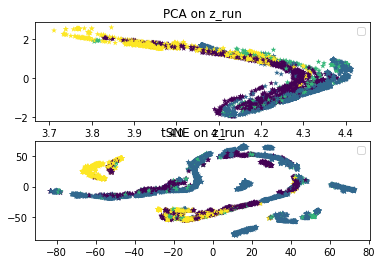

In [39]:
plot_z_run(z_run, label)